# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [1]:
from ecohydr_mod import EcoHyd
import numpy as np

In [2]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

Ecohyd_model = EcoHyd()

In [3]:
import matplotlib.pyplot as plt

In [21]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array)

364
1.9972602739726355
soil moisture sat.: [ 0.14421932  0.14421932  0.14421932 ...,  0.14421932  0.14421932
  0.14421932]
live biomass:  [ 60.23148658  60.23148658  60.23148658 ...,  60.23148658  60.23148658
  60.23148658]
ET:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
ET30:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
PFT:  [0 0 0 ..., 0 0 0]
0
2.000000000000033
soil moisture sat.: [ 0.14182364  0.14182364  0.14182364 ...,  0.14182364  0.14182364
  0.14182364]
live biomass:  [ 59.80865036  59.80865036  59.80865036 ...,  59.80865036  59.80865036
  59.80865036]
ET:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
ET30:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
PFT:  [0 0 0 ..., 0 0 0]
1
2.0027397260274302
soil moisture sat.: [ 0.13476074  0.13476074  0.13476074 ...,  0.13476074  0.13476074
  0.13476074]
live biomass:  [ 0.  0.  0. ...,  0.  0.  0.]
ET:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
ET30:  [ 9.5  9.5  9.5 ...,  9.5  9.5  9.5]
PFT:  [3 3 3 ..., 3 3 3]
2
2.0054794520548276
soil moisture sat.: [ 0.1311963  0

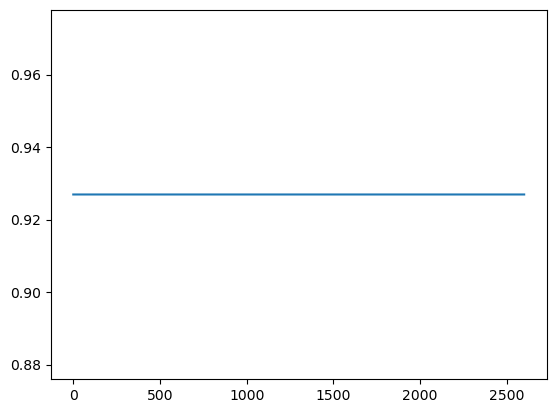

In [22]:
plt.plot(Ecohyd_model.mg.at_cell['rainfall__daily_depth'])

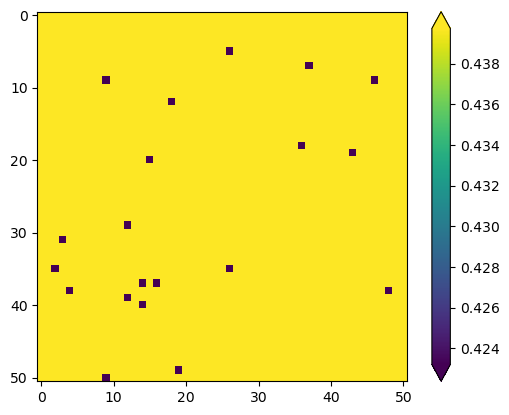

In [23]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['surface__evapotranspiration'], (51,51)))
plt.colorbar(extend = 'both')

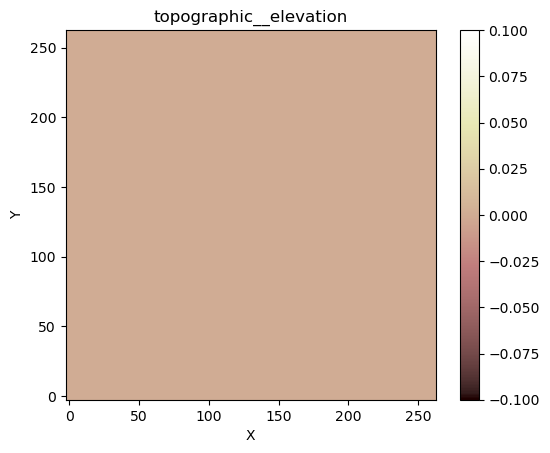

In [24]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

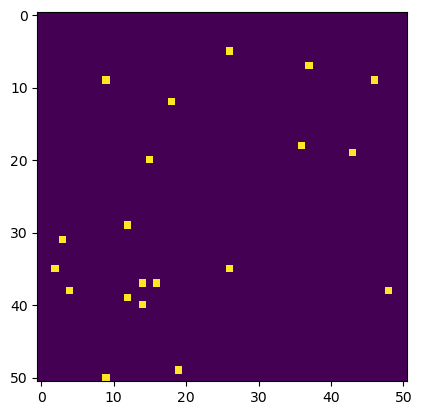

In [25]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

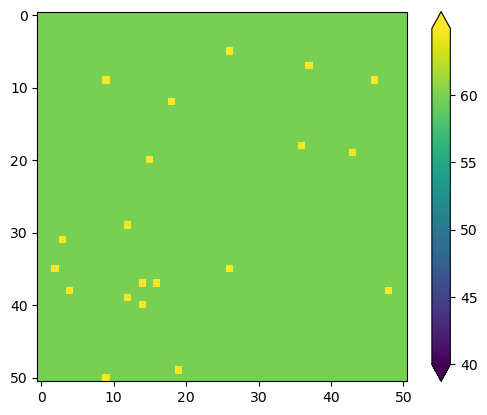

In [26]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
plt.colorbar(extend = 'both')

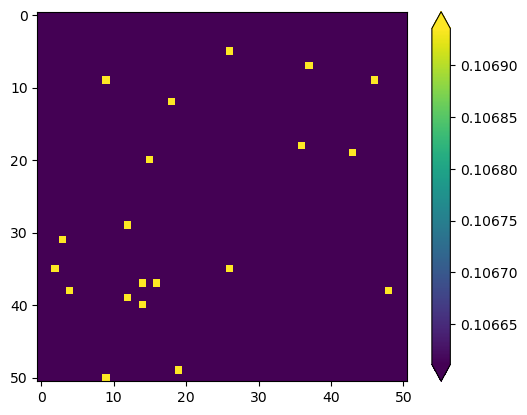

In [10]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.colorbar(extend = 'both')

Why does WSA decrease soil moisture? A bit sus... Maybe there is still enough rainfall that the cover crop interception leads to less SM.

Almost more importantly though, we need to figure out what causes the weird artifact at the bottom of the plot (i.e., the North of the domain). Why is soil moisture there so much lower? As-is, this will dominate any potential effects from WSA.

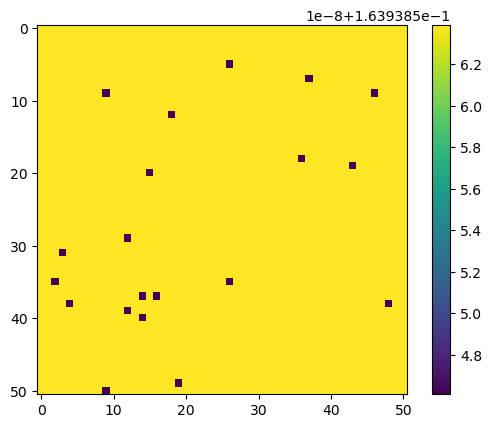

In [11]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.colorbar()

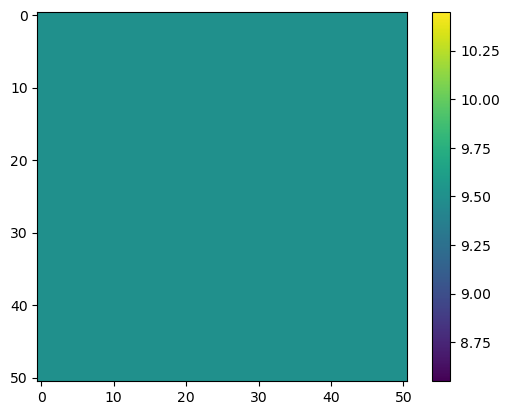

In [12]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

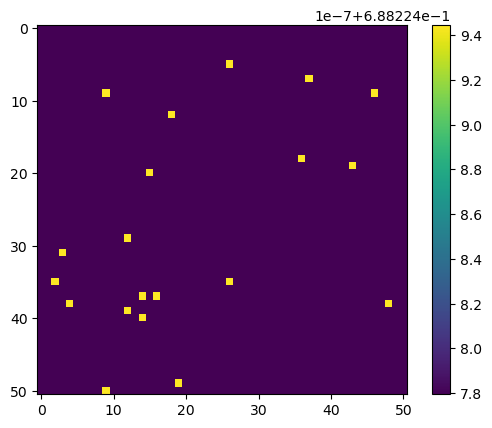

In [13]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

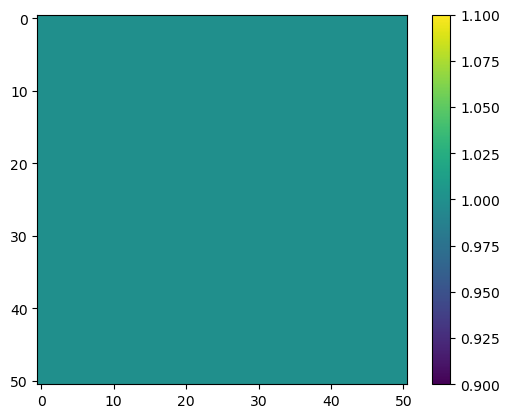

In [14]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()